# Instruction to lab work # 1: "Playing with a single perceptron"

> Student name    - Volodymyr

> Student surname - Donets

> Group           - KU-31


# Tasks of the work




In [2]:
STUDENT_ID = 23

# Code part
## Import dependencies

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Help functions

In [27]:
def gaussian_kernel(center):
    """Factory for a kernel that generates a blob of points."""
    
    # The returned function takes n_points and generates them around the specified center.
    return lambda n: np.repeat(np.array([center]), n, axis=0)


def circle_kernel(radius, start_angle=0, end_angle=2*np.pi):
    """Factory for a kernel that generates points on a circle or arc."""
    
    def _kernel(n):
        theta = np.linspace(start_angle, end_angle, n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T
    return _kernel


def spiral_kernel(rotations=1.5, start_radius=1.0):
    """Factory for a kernel that generates points in a spiral."""
    
    def _kernel(n):
        theta = np.linspace(0, rotations * 2 * np.pi, n)
        radius = np.linspace(start_radius, start_radius + (rotations * 2), n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T
    return _kernel

In [34]:
def generate_classification_data(n_samples=200, kernels=None, kernel_classes=None, 
                                 dispersion=0.2, n_outliers=10, random_seed=42):
    """
    Generates 2D, multi-class data using a flexible kernel-based approach.

    :param n_samples: The total number of data points to generate.
    :param kernels: A list of kernel functions. Each function defines a class and should
                    accept 'n' (number of points) and return an array of shape [n, 2].
    :param kernel_classes: A list of integers mapping each kernel to a class label.
                           Its length must match the length of `kernels`. If None, each kernel
                           is assigned a unique class (e.g., [0, 1, 2, ...]).
    :param dispersion: The standard deviation of Gaussian noise added to each point.
    :param n_outliers: The number of completely random points (noise) to add.
    :param random_seed: A seed for the random number generator for reproducibility.
    :returns: A tuple (X, y) where X is the feature matrix [n_samples, 2]
              and y is the label vector [n_samples,].
    """
    np.random.seed(random_seed)
    
    if kernels is None:
        kernels = [gaussian_kernel(center=[2, 2]), 
                   gaussian_kernel(center=[-2, -2])]
    
    if kernel_classes is None:
        kernel_classes = list(range(len(kernels)))

    if len(kernels) != len(kernel_classes):
        raise ValueError("The length of 'kernels' and 'kernel_classes' must be the same.")
        
    n_classes = len(np.unique(kernel_classes))
    n_inliers = n_samples - n_outliers
    if n_inliers <= 0:
        raise ValueError("n_samples must be greater than n_outliers.")

    points_per_kernel = n_inliers // len(kernels)
    
    X_parts, y_parts = [], []
    for i, kernel in enumerate(kernels):
        class_label = kernel_classes[i]
        
        # --- THE FIX IS ON THIS LINE ---
        # Ensure the kernel output is float before adding float-based dispersion
        X_class = kernel(points_per_kernel).astype(float)
        
        X_class += np.random.randn(points_per_kernel, 2) * dispersion
        y_class = np.full(points_per_kernel, class_label)
        
        X_parts.append(X_class)
        y_parts.append(y_class)
        
    X_inliers = np.vstack(X_parts)
    y_inliers = np.hstack(y_parts)

    if n_outliers > 0:
        x_min, x_max = X_inliers[:, 0].min(), X_inliers[:, 0].max()
        y_min, y_max = X_inliers[:, 1].min(), X_inliers[:, 1].max()
        padding = (max(x_max-x_min, y_max-y_min)) * 0.1
        
        X_outliers = np.random.uniform(min(x_min, y_min) - padding, 
                                       max(x_max, y_max) + padding, 
                                       size=(n_outliers, 2))
        y_outliers = np.random.randint(0, n_classes, size=n_outliers)
        
        X = np.vstack([X_inliers, X_outliers])
        y = np.hstack([y_inliers, y_outliers])
    else:
        X, y = X_inliers, y_inliers

    permutation = np.random.permutation(X.shape[0])
    X, y = X[permutation], y[permutation]
    
    return X, y

In [51]:
# TODO: drop this version of function.
def plot_decision_boundary(X, y, decision_function=None, title="Classification Data"):
    """
    Plots 2D data and visualizes a decision boundary from a function.

    :param X: The feature matrix, shape (n_samples, 2).
    :param y: The label vector, shape (n_samples,).
    :param decision_function: A function that takes two arguments (x1, x2 coordinates)
                              and returns a score. The boundary is where the score is 0.
    :param title: The title for the plot.
    """
    
    plt.style.use('seaborn-v0_8-pastel')
    fig, ax = plt.subplots(figsize=(8, 8))

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                           np.linspace(x2_min, x2_max, 200))

    if decision_function is not None:
        Z = decision_function(xx1, xx2)
        
        ax.contourf(xx1, xx2, Z, levels=[-np.inf, 0, np.inf], colors=['#C4E2FF', '#FFDADA'], alpha=0.6)
        ax.contour(xx1, xx2, Z, levels=[0], colors='k', linestyles='-', linewidths=2)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=0.9, zorder=2)
    
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')
    
    # --- Corrected Legend Creation ---
    # Get the handles (the colored markers) from the scatter plot
    handles, _ = scatter.legend_elements()
    
    # Create custom text labels dynamically based on the number of classes in y
    num_classes = len(np.unique(y))
    class_labels = [f'Class {i}' for i in range(num_classes)]
    
    # If a decision boundary was plotted, add a handle for it to the legend
    if decision_function is not None:
        boundary_handle = plt.Line2D([0], [0], color='k', lw=2)
        handles.append(boundary_handle)
        class_labels.append('Decision Boundary')

    # Create the final legend using the handles and our custom labels
    ax.legend(handles=handles, labels=class_labels, loc='upper right', fontsize=11)
    
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    plt.show()

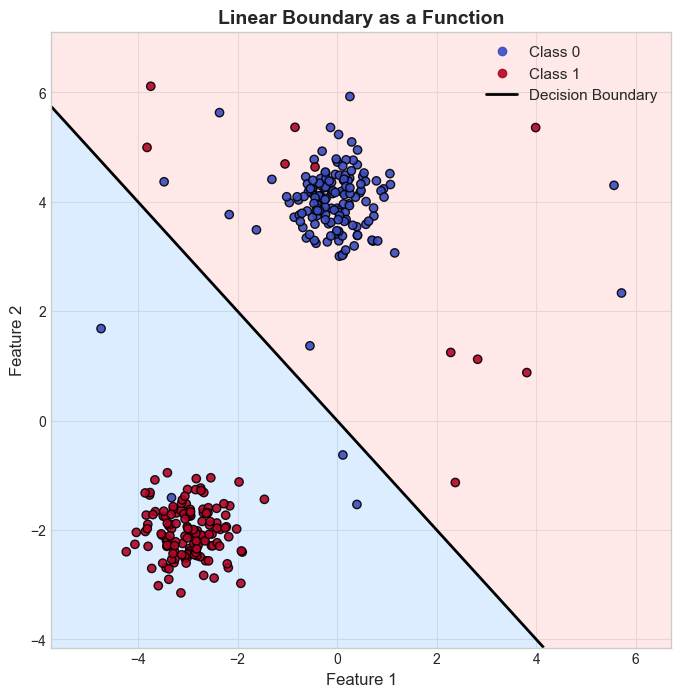

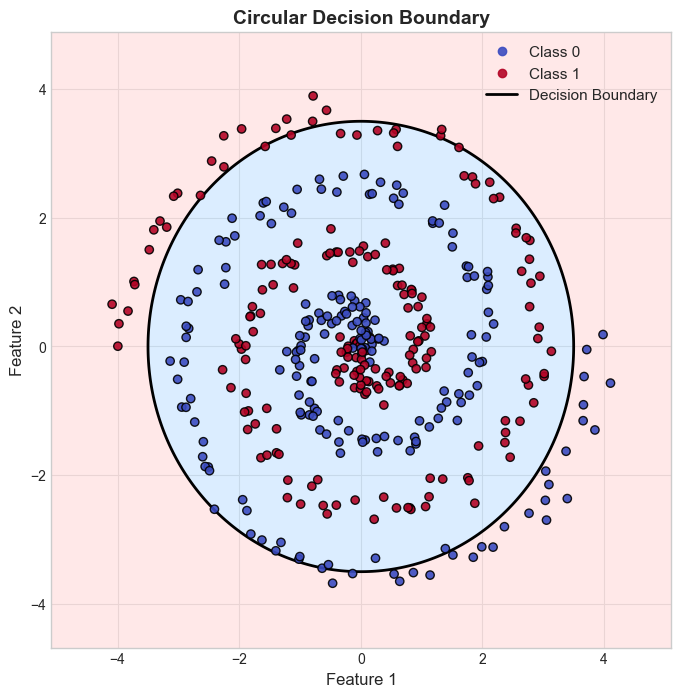

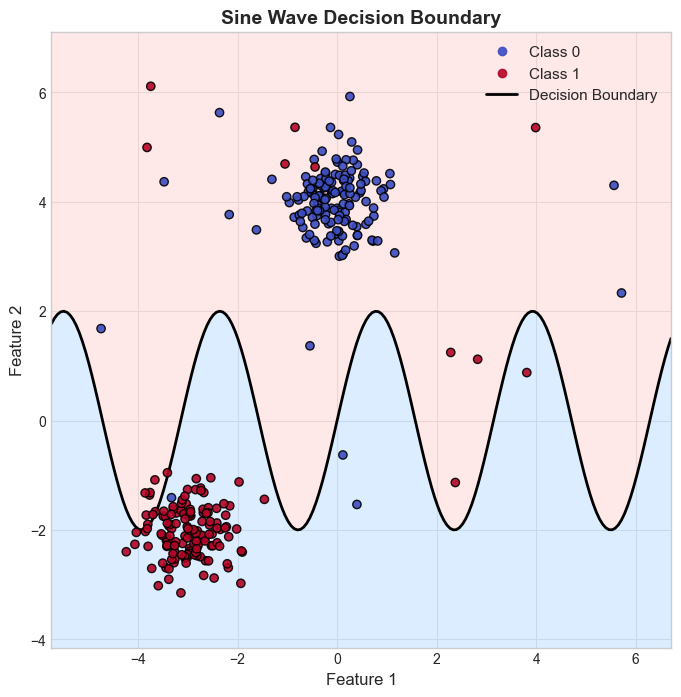

In [53]:
# Assuming generate_classification_data is defined from previous answers
X_linear, y_linear = generate_classification_data(
    n_samples=300,
    kernels=[gaussian_kernel(center=[0, 4]),
             gaussian_kernel(center=[-3, -2]),],
    kernel_classes=[0, 1],
    dispersion=0.5,
    n_outliers=20,
    random_seed=42
)
X_circle, y_circle = generate_classification_data(
    n_samples=400,
    kernels=[
        spiral_kernel(rotations=2, start_radius=0),
        lambda n: -1 * spiral_kernel(rotations=2, start_radius=0)(n) # Invert the second spiral
    ],
    kernel_classes=[0, 1],
    dispersion=0.15,
    n_outliers=0,
    random_seed=42
)

# f(x1, x2) = 0.8*x1 + 0.8*x2 + 0
linear_boundary = lambda x1, x2: 0.8 * x1 + 0.8 * x2

plot_decision_boundary(X_linear, y_linear, decision_function=linear_boundary,
                       title="Linear Boundary as a Function")

# The equation for a circle boundary: x₁² + x₂² - radius² = 0
# Points inside the circle will have a negative score, points outside positive.
circular_boundary = lambda x1, x2: x1**2 + x2**2 - 3.5**2

plot_decision_boundary(X_circle, y_circle, decision_function=circular_boundary,
                       title="Circular Decision Boundary")

# A sine wave boundary: x₂ - sin(x₁) = 0
wave_boundary = lambda x1, x2: x2 - np.sin(x1 * 2) * 2

plot_decision_boundary(X_linear, y_linear, decision_function=wave_boundary,
                       title="Sine Wave Decision Boundary")

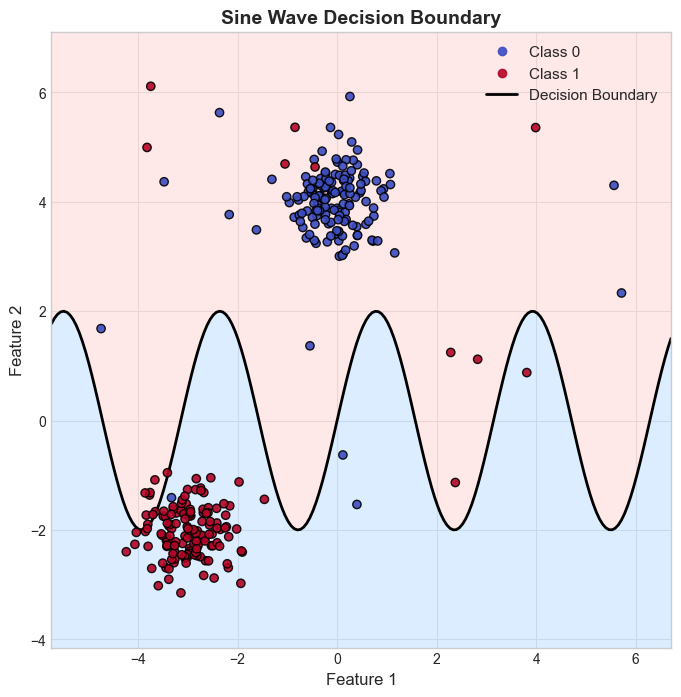

In [54]:
# A sine wave boundary: x₂ - sin(x₁) = 0
wave_boundary = lambda x1, x2: x2 - np.sin(x1 * 2) * 2

plot_decision_boundary(X_linear, y_linear, decision_function=wave_boundary,
                       title="Sine Wave Decision Boundary")

In [61]:
def plot_decision_boundary(X, y, decision_functions=None, combination_rule=None, title="Classification Data"):
    """
    Plots data and visualizes a complex decision boundary formed by combining multiple functions.

    :param X: The feature matrix, shape (n_samples, 2).
    :param y: The label vector, shape (n_samples,).
    :param decision_functions: A list of functions, where each takes two arguments (x1, x2) and returns a score.
    :param combination_rule: A function that takes a NumPy array of all function scores (shape: [n_functions, n_points, n_points]) 
                             and returns a single final score grid.
    :param title: The title for the plot.
    """
    
    plt.style.use('seaborn-v0_8-pastel') # Using compatible style name
    fig, ax = plt.subplots(figsize=(8, 8))

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                           np.linspace(x2_min, x2_max, 200))

    if decision_functions is not None and combination_rule is not None:
        all_Z = np.array([fn(xx1, xx2) for fn in decision_functions])
        final_Z = combination_rule(all_Z)
        
        ax.contourf(xx1, xx2, final_Z, levels=[-np.inf, 0, np.inf], colors=['#C4E2FF', '#FFDADA'], alpha=0.6)
        
        for i, Z in enumerate(all_Z):
            ax.contour(xx1, xx2, Z, levels=[0], colors='gray', linestyles='--', linewidths=1.5)

        ax.contour(xx1, xx2, final_Z, levels=[0], colors='k', linestyles='-', linewidths=2.5)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=0.9, zorder=2)
    
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')
    
    # --- Corrected Legend Creation ---
    # Get the handles (the colored markers) from the scatter plot
    handles, _ = scatter.legend_elements()
    
    # Create custom text labels dynamically
    num_classes = len(np.unique(y))
    class_labels = [f'Class {i}' for i in range(num_classes)]
    
    # If boundaries were plotted, create proxy artists for them and add to the legend
    if decision_functions is not None and combination_rule is not None:
        individual_h = plt.Line2D([0], [0], color='gray', linestyle='--', lw=1.5)
        final_h = plt.Line2D([0], [0], color='k', linestyle='-', lw=2.5)
        
        handles.extend([individual_h, final_h])
        class_labels.extend(['Individual Boundaries', 'Final Boundary'])

    # Create the final legend using the correct handles and our custom labels
    ax.legend(handles=handles, labels=class_labels, loc='upper right', fontsize=11)
    
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    plt.show()

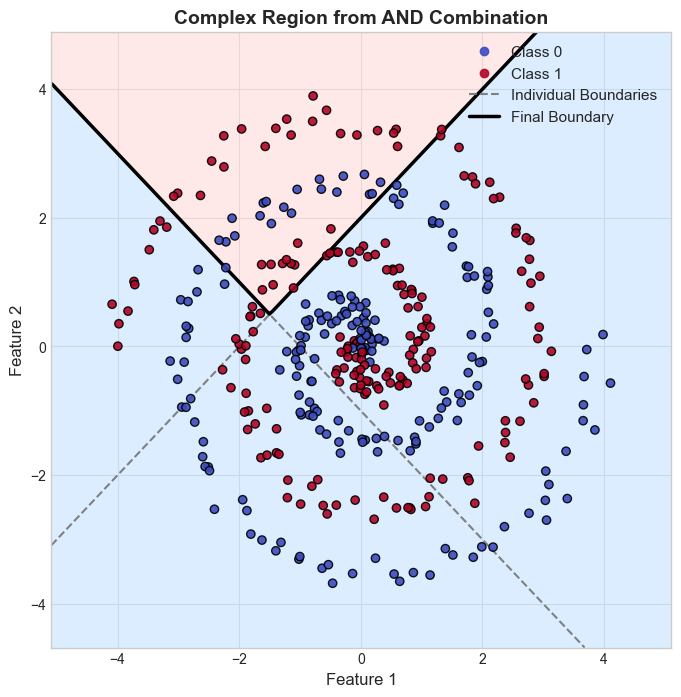

In [62]:
# Assuming generate_classification_data is defined
# Generate some data blobs
X_data, y_data = generate_classification_data(
    n_samples=400,
    kernels=[
        spiral_kernel(rotations=2, start_radius=0),
        lambda n: -1 * spiral_kernel(rotations=2, start_radius=0)(n) # Invert the second spiral
    ],
    kernel_classes=[0, 1],
    dispersion=0.15,
    n_outliers=0,
    random_seed=42
)

# Define two individual "hidden neurons" (linear boundaries)
boundary1 = lambda x1, x2: 1.0 * x1 + 1.0 * x2 + 1.0
boundary2 = lambda x1, x2: -1.0 * x1 + 1.0 * x2 - 2.0

# Define the "output neuron" as a logical AND combination rule
# This will classify a point as Class 1 only if it's "activated" by BOTH individual functions.
rule_AND = lambda Z_stack: np.min(Z_stack, axis=0)

# Call the plotting function
plot_decision_boundary(X_data, y_data,
                       decision_functions=[boundary1, boundary2],
                       combination_rule=rule_AND,
                       title="Complex Region from AND Combination")

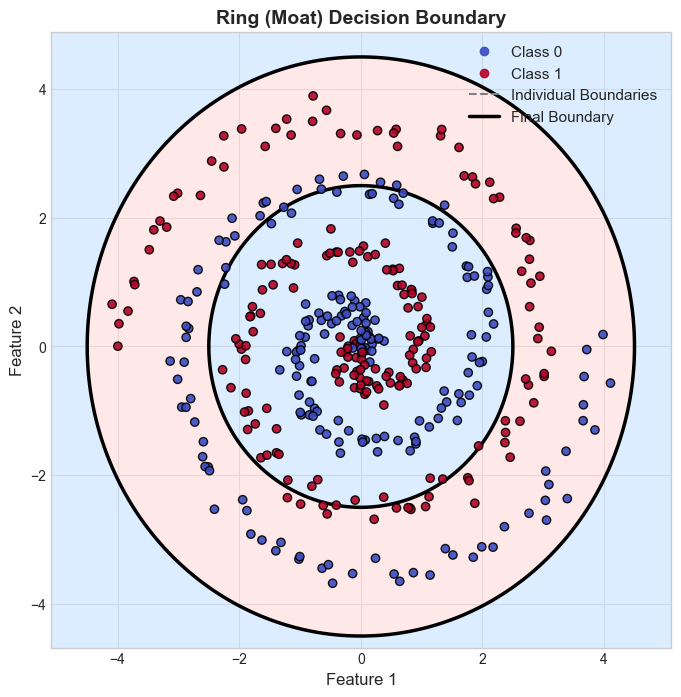

In [63]:
# Define the two circular boundaries
inner_boundary = lambda x1, x2: x1**2 + x2**2 - 2.5**2  # We want points where this is > 0
outer_boundary = lambda x1, x2: 4.5**2 - (x1**2 + x2**2) # We want points where this is > 0

# The combination rule is a logical AND.
# A point is in the final region if its score is positive for BOTH boundaries.
rule_AND = lambda Z_stack: np.min(Z_stack, axis=0)

plot_decision_boundary(X_circle, y_circle,
                       decision_functions=[inner_boundary, outer_boundary],
                       combination_rule=rule_AND,
                       title="Ring (Moat) Decision Boundary")

C:\Users\voldo\AppData\Local\Temp\ipykernel_21764\679330389.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([], [], 'k--', color='gray', lw=1.5, label='Individual Boundaries')


AttributeError: 'Line2D' object has no attribute 'get_facecolor'

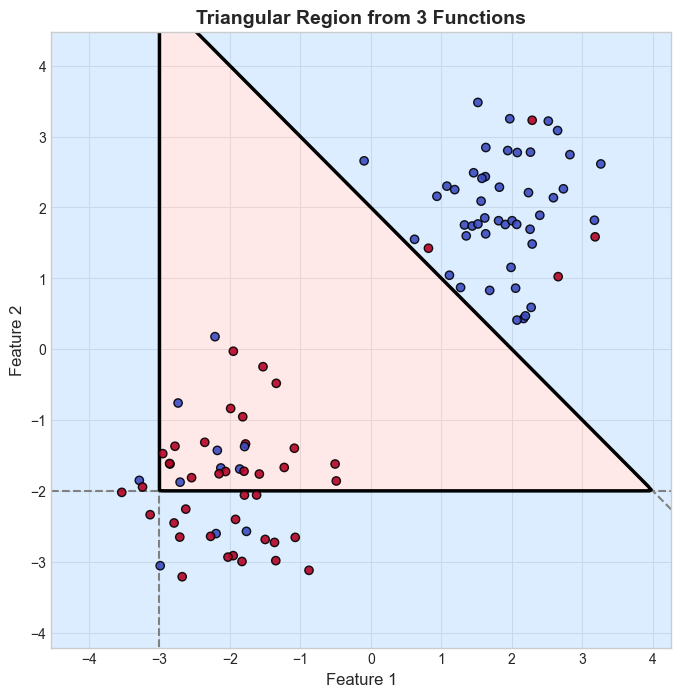

In [26]:
# Assuming generate_classification_data and plot_decision_boundary are defined
X_data, y_data = generate_classification_data(pattern='gaussian', noise=0.8, n_outliers=15, random_seed=42)

# Define three linear boundaries that will form a triangle
boundary_bottom = lambda x1, x2: x2 + 2.0  # Positive for y > -2
boundary_left   = lambda x1, x2: x1 + 3.0  # Positive for x > -3
boundary_right  = lambda x1, x2: -x1 - x2 + 2.0  # Positive for y < -x + 4

# The combination rule is a logical AND. A point is in the final region
# only if its score is positive for ALL three boundaries.
rule_AND = lambda Z_stack: np.min(Z_stack, axis=0)

# Call the function with a list of three decision functions
plot_decision_boundary(X_data, y_data,
                       decision_functions=[boundary_bottom, boundary_left, boundary_right],
                       combination_rule=rule_AND,
                       title="Triangular Region from 3 Functions")

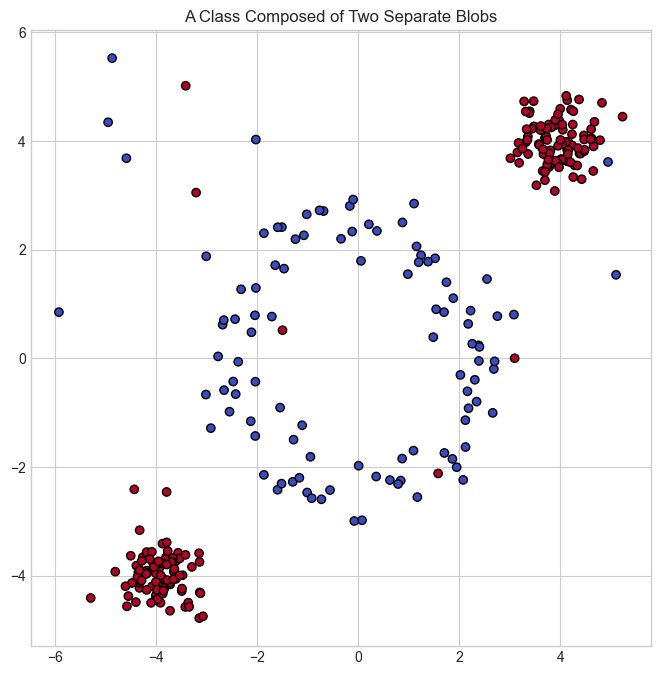

In [37]:
# Assuming kernel factory functions (gaussian_kernel, circle_kernel) are defined

# 1. Define the list of three shapes (kernels)
kernels_list = [
    circle_kernel(radius=2.5),          # This will be for class 0
    gaussian_kernel(center=[-4, -4]),   # This will be part of class 1
    gaussian_kernel(center=[4, 4])      # This will also be part of class 1
]

# 2. Define the mapping from kernels to classes
# The first kernel is class 0, the next two are both class 1.
class_mapping = [0, 1, 1]

# 3. Generate the data
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=kernels_list,
    kernel_classes=class_mapping,
    dispersion=0.4,
    n_outliers=15,
    random_seed=42
)

# 4. Plot the result
plt.figure(figsize=(8, 8))
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("A Class Composed of Two Separate Blobs")
plt.show()

## Experiments and task examples

# Conclusions on work